In [22]:
!pip install duckdb
!pip install rdkit

In [23]:
import numpy as np
import pandas as pd
import duckdb
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import time

In [24]:
train = pd.read_csv('/kaggle/input/leash-BELKA/train.csv', nrows=1000)
train.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0


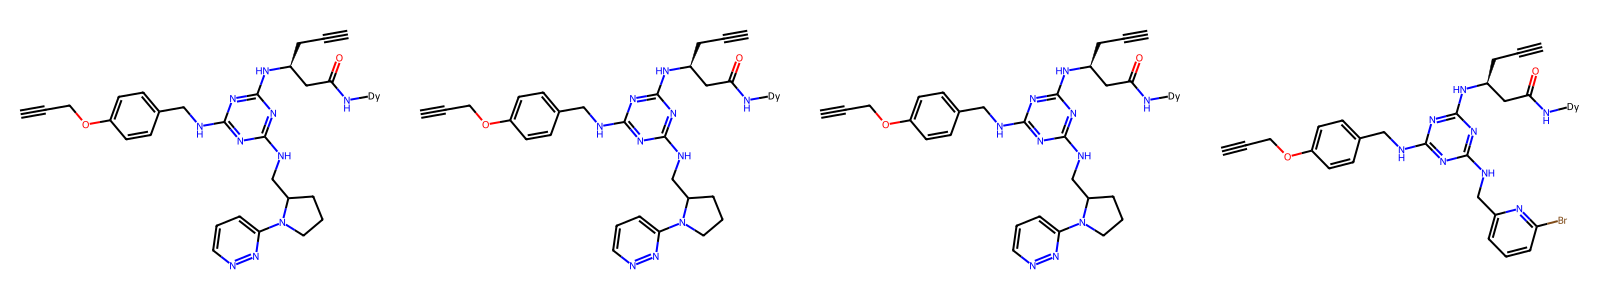

In [25]:
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in train['molecule_smiles'][0:4]], molsPerRow=4, subImgSize=(400,300))

In [26]:
train_path = '/kaggle/input/leash-BELKA/train.parquet'
test_path = '/kaggle/input/leash-BELKA/test.parquet'

con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 10000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 10000)""").df()

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [27]:
df.tail()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
19995,65238353,N#Cc1ccc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)...,Nc1ccc2c(c1)CNCC2,CC(CN)c1c(Cl)cccc1Cl,CC(CNc1nc(Nc2ccc3c(c2)CNCC3)nc(N[C@H](Cc2ccc(C...,sEH,1
19996,81817685,O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,CCOC(=O)c1cnc(SC)nc1N,Nc1ccc2c(c1)C(O)CCC2,CCOC(=O)c1cnc(SC)nc1Nc1nc(NCC2CCC(C(=O)N[Dy])C...,sEH,1
19997,82806983,O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2...,C=C1CCC(CN)CC1.Cl,CS(=O)(=O)c1ccc(N)cc1F,C=C1CCC(CNc2nc(NC[C@H]3CC[C@H](C(=O)N[Dy])CC3)...,sEH,1
19998,18893868,CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(...,Cc1cc(N)ncc1Cl,NCCS(=O)Cc1ccccc1,Cc1cc(Nc2nc(NCCS(=O)Cc3ccccc3)nc(NC(C(=O)N[Dy]...,BRD4,1
19999,127282050,O=C(N[C@H](Cc1ccccc1Cl)C(=O)O)OCC1c2ccccc2-c2c...,Nc1ccc(F)c(Cl)c1F,Nc1ccc2c(c1)CNC2=O,O=C1NCc2cc(Nc3nc(Nc4ccc(F)c(Cl)c4F)nc(N[C@H](C...,BRD4,1


In [28]:
df["protein_name"].value_counts()

protein_name
sEH     7928
BRD4    6309
HSA     5763
Name: count, dtype: int64

## Converting SMILES Representations of Molecules to RDKit Molecular Objects
The SMILES (Simplified Molecular Input Line Entry System) format is a textual format for describing the structure of chemical molecules. RDKit provides tools for working with molecules, such as visualization, calculation of chemical properties, and generation of molecular fingerprints.
ECFP (Extended Connectivity Fingerprints), also known as Morgan fingerprints, are numerical representations of molecules used to capture their structural features. These fingerprints are created by iteratively considering atomic environments in the molecule and encoding them into bit vectors. They are useful for various tasks, including searching for similar molecules, clustering, classification, and docking. In this case, generate_ecfp creates a bit vector for each molecule using a radius of 2 and a vector length of 1024 bits.
Using ECFP, it is easy to compare molecules and analyze their similarities and differences.

Radius (radius=2)
The radius determines how far from each atom in the molecule to search for its environment to include it in the fingerprint. In this case, a radius of 2 means that atoms and bonds up to two steps away from each atom are considered (i.e., the central atom, its immediate neighbors, and the neighbors of those neighbors).

Choosing a radius of 2 is a compromise between detail and complexity: it is considered informative enough to capture key structural features of the molecule without excessively increasing the dimensionality of the data. This allows for effectively distinguishing between different molecules and classifying them.
Smaller radius values may not capture important structural features of the molecule.
Larger radius values may capture too much detail, leading to redundancy and complicating analysis.
Vector length (bits=1024)
The length of the bit vector determines how many bits will be in the fingerprint. In this case, 1024 bits are used.

Choosing a vector length of 1024 bits is also a compromise: it is considered a good balance between spatial costs and resolution. This allows molecules to be represented with enough detail to distinguish them while maintaining a manageable data size.
Smaller bit values may lead to information loss and increase the likelihood of collisions (different molecules may have the same fingerprints).
Larger bit values may provide more information but increase data volume and computational load.
These values (radius=2 and bits=1024) are widely used in literature and practice because they offer a good compromise between detail, accuracy, and computational efficiency.

In [29]:
%%time

# Convert SMILES to RDKit molecules
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)

# Generate ECFPs
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

df['ecfp'] = df['molecule'].apply(generate_ecfp)

CPU times: user 27.7 s, sys: 55.8 ms, total: 27.7 s
Wall time: 27.7 s


In [30]:
print(df['ecfp'].head())

0    [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: ecfp, dtype: object


In [31]:
# Checking for duplicates by SMILES
duplicate_smiles = df[df.duplicated('molecule_smiles')]['molecule_smiles'].unique()
print("Количество уникальных дубликатов SMILES:", len(duplicate_smiles))

Количество уникальных дубликатов SMILES: 5


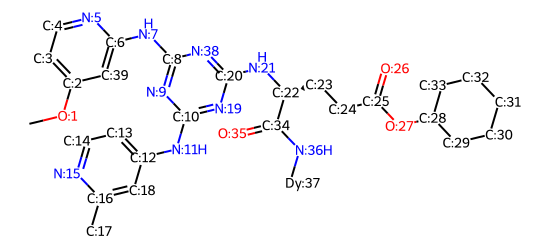

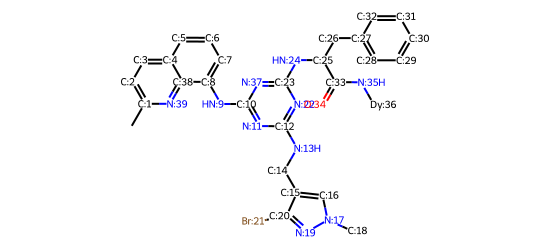

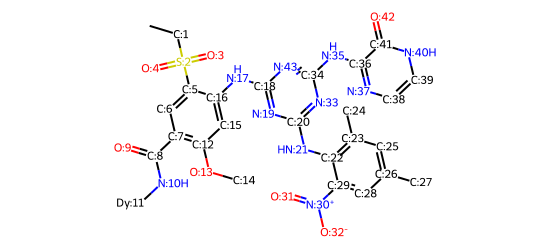

In [32]:
# Visualization of molecules with atomic indices
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

for idx, row in df.head(3).iterrows():
    mol = mol_with_atom_index(row['molecule'])
    drawer = Draw.MolDraw2DSVG(550, 250)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace('svg:', '')))

In [33]:
df.head(2)

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,molecule,ecfp
0,71184518,O=C(CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)...,Cc1cc(N)ccn1,COc1ccnc(N)c1,COc1ccnc(Nc2nc(Nc3ccnc(C)c3)nc(N[C@@H](CCC(=O)...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x7c9ba441bf40>,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,74487542,O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,Cc1ccc2cccc(N)c2n1,Cl.Cn1cc(CN)c(Br)n1,Cc1ccc2cccc(Nc3nc(NCc4cn(C)nc4Br)nc(NC(Cc4cccc...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x7c9ba441bdf0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [34]:
all_blocks = pd.concat([df.buildingblock1_smiles, df.buildingblock2_smiles, df.buildingblock3_smiles])

all_blocks.value_counts().head(20)

O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21              1692
O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21      1069
Cl.Cl.NCc1cncc(F)c1                                         561
Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-]                             434
Cc1cc2cc(CN)ccc2[nH]1                                       363
Cl.Cn1cc(N)ccc1=O                                           361
Nc1ccc2c(c1)CNC2=O                                          256
CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O                 250
CCOC(=O)c1ncccc1N                                           242
CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O          217
Cl.Cl.NCc1ccc(O)c2ncccc12                                   217
O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21                212
Cl.NCc1cnc2n1CCOC2                                          210
NCCC1CSC1                                                   206
O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21              202
O=C(O)[C@@H]1Cc2ccc(O)cc2CN1C(=O)OCC1c2c

In [35]:
%%time

import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import lightgbm as lgb

# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))

# Combine ECFPs and one-hot encoded protein_name
X = [ecfp + protein for ecfp, protein in zip(df['ecfp'].tolist(), protein_onehot.tolist())]
y = df['binds'].tolist()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Probability of the positive class
map_score_rf = average_precision_score(y_test, y_pred_proba_rf)
print(f"RandomForest Mean Average Precision (mAP): {map_score_rf:.2f}")

# XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:,1]
map_score_xgb = average_precision_score(y_test, y_pred_proba_xgb)
print(f"XGBoost Mean Average Precision (mAP): {map_score_xgb:.2f}")

# LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]  # Probability of the positive class
map_score_lgb = average_precision_score(y_test, y_pred_proba_lgb)
print(f"LightGBM Mean Average Precision (mAP): {map_score_lgb:.2f}")

RandomForest Mean Average Precision (mAP): 0.95
XGBoost Mean Average Precision (mAP): 0.96
LightGBM Mean Average Precision (mAP): 0.96
CPU times: user 36.8 s, sys: 310 ms, total: 37.1 s
Wall time: 24.1 s


In [36]:
%%time
predict_test = (rf_model.predict_proba(X_test)[:, 1] * 0.30) + (xgb_model.predict_proba(X_test)[:, 1] * 0.30) + (lgb_model.predict_proba(X_test)[:, 1] * 0.40)
score = average_precision_score(y_test, predict_test) 
score

CPU times: user 1.71 s, sys: 3.05 ms, total: 1.72 s
Wall time: 1.56 s


0.9586062258239914

In [37]:
%%time

# Defining a function to generate ECFP
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

test_file = '/kaggle/input/leash-BELKA/test.csv'
sample_submission_file = '/kaggle/input/leash-BELKA/sample_submission.csv'
output_file = 'submission.csv'
df_test = pd.read_csv(test_file, nrows=10000)

# Generating ECFP for the molecule_smiles
df_test['molecule'] = df_test['molecule_smiles'].apply(Chem.MolFromSmiles)
df_test['ecfp'] = df_test['molecule'].apply(generate_ecfp)

# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoder.fit(df['protein_name'].values.reshape(-1, 1))
protein_onehot_test = onehot_encoder.transform(df_test['protein_name'].values.reshape(-1, 1))

# Combining ECFP and one-hot encoded data
X_test = [ecfp + protein for ecfp, protein in zip(df_test['ecfp'].tolist(), protein_onehot_test.tolist())]

# Predict probabilities using an ensemble of models
predict_test = (rf_model.predict_proba(X_test)[:, 1] * 0.30) + \
               (xgb_model.predict_proba(X_test)[:, 1] * 0.30) + \
               (lgb_model.predict_proba(X_test)[:, 1] * 0.40)

# Uploading sample_submission.csv
output_df = pd.read_csv(sample_submission_file)

# Update the first 10,000 rows in sample_submission.csv with our forecasts
output_df.loc[0:9999, 'binds'] = predict_test

# Saving the updated file
output_df.to_csv(output_file, index=False)

CPU times: user 22.1 s, sys: 136 ms, total: 22.2 s
Wall time: 21.9 s


In [38]:
output_df

,id,binds
0,295246830,0.352498
1,295246831,0.250356
2,295246832,0.166979
3,295246833,0.434188
4,295246834,0.340669
...,...,...
1674891,296921721,0.500000
1674892,296921722,0.500000
1674893,296921723,0.500000
1674894,296921724,0.500000


In [39]:
submission_df = pd.read_csv(output_file)
print(submission_df.head())

          id     binds
0  295246830  0.352498
1  295246831  0.250356
2  295246832  0.166979
3  295246833  0.434188
4  295246834  0.340669


In [40]:
df_sample_submission = pd.read_csv(sample_submission_file)
print(df_sample_submission.head())

          id  binds
0  295246830    0.5
1  295246831    0.5
2  295246832    0.5
3  295246833    0.5
4  295246834    0.5
